In [44]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [45]:
import tensorflow as tf
import os

In [46]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [47]:
tf.config.list_physical_devices('GPU')

[]

In [48]:
import cv2
import imghdr

In [49]:
data_dir = 'data'

In [50]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [51]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

libpng warning: iCCP: known incorrect sRGB profile


In [52]:
import numpy as np
from matplotlib import pyplot as plt

In [53]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 155 files belonging to 2 classes.


In [54]:
data_iterator = data.as_numpy_iterator()

In [55]:
batch = data_iterator.next()

2024-02-05 11:32:21.072686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [56]:
# 1 = Skyline
# 0 = BMW
batch[1]

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int32)

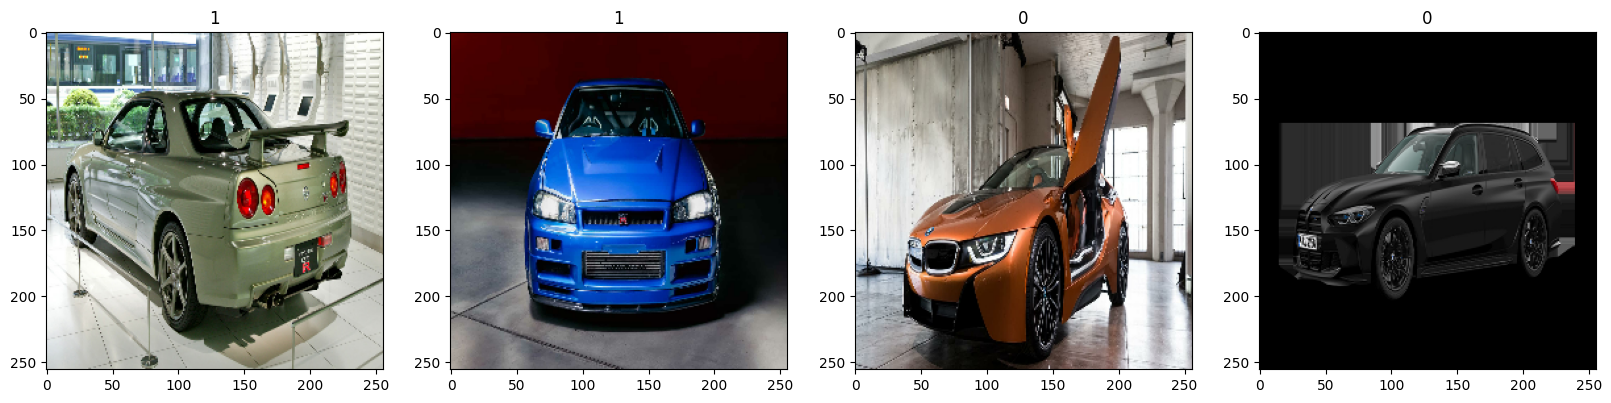

In [57]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [58]:
data = data.map(lambda x, y: (x/255, y))

In [59]:
data.as_numpy_iterator().next()

2024-02-05 11:32:21.965386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


(array([[[[0.79600066, 0.74953926, 0.70283514],
          [0.8066866 , 0.75804275, 0.7101914 ],
          [0.7962733 , 0.7570576 , 0.7099987 ],
          ...,
          [0.71352994, 0.82114667, 0.85777944],
          [0.8446186 , 0.8291284 , 0.8172983 ],
          [0.8101074 , 0.79918814, 0.7878777 ]],
 
         [[0.8984033 , 0.8800286 , 0.84383833],
          [0.90875006, 0.8797028 , 0.8409912 ],
          [0.8909697 , 0.8638557 , 0.8167969 ],
          ...,
          [0.7725112 , 0.8645455 , 0.8975112 ],
          [0.7797227 , 0.8130529 , 0.8231158 ],
          [0.70950186, 0.7325023 , 0.7387099 ]],
 
         [[0.90588236, 0.8901961 , 0.84705883],
          [0.9053512 , 0.88966495, 0.8465277 ],
          [0.8903945 , 0.85902196, 0.8158847 ],
          ...,
          [0.78551626, 0.832587  , 0.8367355 ],
          [0.34591278, 0.35142225, 0.3391087 ],
          [0.60282487, 0.55219513, 0.5505211 ]],
 
         ...,
 
         [[0.4935992 , 0.47641936, 0.46693116],
          [0.31549

In [60]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [61]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [63]:
model = Sequential()

In [64]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [65]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

In [67]:
logdir = 'logs'

In [68]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2024-02-05 11:32:22.886424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


In [ ]:
print(pre.result(), re.result(), acc.result())

In [ ]:
import cv2

In [ ]:
img = cv2.imread('BMWTest3.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [35]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 17ms/step


In [41]:
yhat

array([[0.9978246]], dtype=float32)

In [37]:
if yhat > 0.5: 
    print(f'Predicted class is Skyline!')
else:
    print(f'Predicted class is BMW!')

Predicted class is Skyline!


In [38]:
from tensorflow.keras.models import load_model

In [39]:
model.save(os.path.join('models','SkylineDetector.h5'))

/home/semka/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
model.save(os.path.join('models','SkylineDetector.keras'))

In [42]:
new_model = load_model(os.path.join('models', 'SkylineDetector.keras'))

In [171]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 48ms/step


array([[1.]], dtype=float32)